# Graven in _De Gids_
Onderstaande notebook geeft een overzicht van het analyseren van de uitkomst van een topic model. Dit model is getraind op een corpus van de eerste honderd jaargangen van algemeen cultureel tijdschrift _De Gids_ (1837-) en is, in tegenstelling tot het corpus, meegeleverd met deze repository. 

Het `FoliaCorpus` bevat een woordenboek en een koppeling tussen een numerieke en textuele representatie van de individuele woorden uit het corpus. Het `mcorpus` is een abstractie van de teksten waarin er gefilterd is op vaakvoorkomende (functie)woorden en woorden die slechts een paar keer voorkomen. Het model is een gensim LDA-model. 

## Reading the files

In [1]:
import os

from modules.DeGids.DeGids import FoliaCorpus
from modules.DeGids.DeGids import DeGids

%matplotlib inline
from collections import defaultdict
import pandas as pd
from matplotlib2tikz import save as tikz_save

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle

from IPython.core import display as ICD

In [2]:
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

2019-03-17 12:37:59,975 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# Only if access to this corpus
# CORPUS = "/mnt/scistor1/group/home/vanwissen/degids_1837_1936/"
# METAFILES = "/home/vanwissen/degids/data/metadata_auteursinformatie/"

### Corpus

In [4]:
# fcorpus = FoliaCorpus(corpuspath=CORPUS,
#                             metafiles=METAFILES, 
#                             dictionary=None, 
#                             years=(1837, 1936), 
#                             lemma=True, 
#                             add_entities=True, 
#                             remove_stopwords=True, 
#                             stopwordsfile='../../data/stoplist_dutch.txt',  
#                             remove_accents=True, 
#                             remove_nonalpha=True, 
#                             remove_punctuation=True, 
#                             remove_hyphenation=True, 
#                             remove_apostrophe=True, 
#                             transform_lowercase=True,
#                             gzipped=False
#                            )

In [5]:
# fcorpus.statistics

#### Filtering

In [6]:
# fcorpus.filter(min_dfs=5, max_dfs=0.75, min_tfs=15)

In [24]:
fcorpus.statistics

{'tokens': 22674403, 'vocabulary size': 73963, 'documents:': 10624}

#### Saving

In [25]:
# fcorpus.serialize('data/corpus/1836-1936')

## Loading the mmCorpora

In [26]:
# Load an abstraction of the real corpus
mcorpus = MmCorpus('data/corpus/1837-1936.mmcorpus')

# Load the folia corpus for retrieving the dictionary
with open('data/corpus/1837-1936.foliacorpus', 'rb') as picklefile:
    fcorpus = pickle.load(picklefile)

2019-03-17 15:17:08,058 : INFO : loaded corpus index from data/corpus/1837-1936.mmcorpus.index
2019-03-17 15:17:08,061 : INFO : initializing cython corpus reader from data/corpus/1837-1936.mmcorpus
2019-03-17 15:17:08,063 : INFO : accepted corpus with 10624 documents, 73963 features, 11606823 non-zero entries


### Aantal topics
Wat experimenteren met verschillende modellen en hun topicverdeling, blijkt dat een model van 300 topics de juiste informatie weergeeft. 


In [27]:
# model = get_model(300, mcorpus, fcorpus, filename="model/1837-1936_300.model")

In [28]:
model = LdaModel.load('model/1837-1936_300.model')

2019-03-17 15:17:09,476 : INFO : loading LdaModel object from model/1837-1936_300.model
2019-03-17 15:17:09,477 : INFO : loading expElogbeta from model/1837-1936_300.model.expElogbeta.npy with mmap=None
2019-03-17 15:17:09,505 : INFO : setting ignored attribute id2word to None
2019-03-17 15:17:09,506 : INFO : setting ignored attribute dispatcher to None
2019-03-17 15:17:09,506 : INFO : setting ignored attribute state to None
2019-03-17 15:17:09,506 : INFO : loaded model/1837-1936_300.model
2019-03-17 15:17:09,507 : INFO : loading LdaState object from model/1837-1936_300.model.state
2019-03-17 15:17:09,508 : INFO : loading sstats from model/1837-1936_300.model.state.sstats.npy with mmap=None
2019-03-17 15:17:09,545 : INFO : loaded model/1837-1936_300.model.state


#### Printing usefull information for LaTeX

Build a list of topics with extra information, such as the most distinctive document and the topic proportion for usage in LaTeX (the thesis). This is saved to a file. 

In [12]:
def get_topic_proportion(model, mcorpus, fcorpus):
    """
    Calculate the topic proportions by using the
    same measurement as pyLDAvis. 
    """
    
    from pyLDAvis.gensim import _extract_data
    import pandas as pd
        
    doc_topic_dists, doc_lengths = (_extract_data(model, mcorpus, fcorpus.dictionary)['doc_topic_dists'],
                                    _extract_data(model, mcorpus, fcorpus.dictionary)['doc_lengths'])

    doc_topic_dists = pd.DataFrame(doc_topic_dists)
    doc_topic_dists.index.name = 'doc'
    doc_topic_dists.columns.name = 'topic'

    doc_lengths = pd.Series(doc_lengths, name='doc_length')
    topic_freq = (doc_topic_dists.T * doc_lengths).T.sum()

    topic_proportion = (topic_freq / topic_freq.sum()).sort_values(ascending=False)
    
    return topic_proportion

In [13]:
proportion = get_topic_proportion(model, mcorpus, fcorpus)

<hr>

## Annoteren en categoriseren

Elk van de 300 topics uit het model is geannoteerd met een label of een restcategorie. 

In [14]:
import csv

with open('data/annotaties.csv') as infile:
    lines = csv.reader(infile)
    next(lines)
    topics_labels = sorted([int(i[0]), i[1].split(', ')] for i in lines)

In [15]:
topics_labels[:10]

[[0, ['letterkunde', 'theologie']],
 [1, ['?']],
 [2, ['geneeskunde']],
 [3, ['geschiedenis']],
 [4, ['antropologie', 'biologie']],
 [5, ['geschiedenis']],
 [6, ['literatuur']],
 [7, ['letterkunde']],
 [8, ['politicologie']],
 [9, ['theologie']]]

In [16]:
labels = set(i for labels in topics_labels for i in labels[1])
labels

{'?',
 'antropologie',
 'biologie',
 'criminologie',
 'economie',
 'filosofie',
 'geneeskunde',
 'geografie',
 'geologie',
 'geschiedenis',
 'kunst',
 'kunstgeschiedenis',
 'letterkunde',
 'literatuur',
 'musicologie',
 'natuurkunde',
 'oudheidkunde',
 'pedagogie',
 'politicologie',
 'psychologie',
 'rechten',
 'scheikunde',
 'sociologie',
 'taal: Duits',
 'taal: Engels',
 'taal: Frans',
 'taal: Oud-Nederlands',
 'taalkunde',
 'theologie',
 'wiskunde'}

Reverse the table so that the label groups all the topics it is attached to:

In [17]:
disciplines = defaultdict(list)
for topic, labels in topics_labels:
    for label in labels:
        disciplines[label].append(topic)

In [18]:
alpha = ['kunstgeschiedenis', 'oudheidkunde', 'geschiedenis', 'taalkunde', 'letterkunde', 'musicologie', 'filosofie', 'theologie']
beta = ['biologie', 'scheikunde', 'geologie', 'geneeskunde', 'wiskunde', 'natuurkunde']
gamma = ['antropologie', 'criminologie', 'economie', 'geografie', 'rechten', 'pedagogie', 'politicologie', 'psychologie', 'sociologie']

other = ['?', 'kunst', 'literatuur', 'taal: Engels', 'taal: Frans', 'taal: Duits', 'taal: Oud-Nederlands']

And now a nice table for LaTeX:

In [19]:
field_discipline_proportions = defaultdict(list)
field_proportions = []

for fieldname, field in zip(['Geesteswetenschappen', 'Natuurwetenschappen', 'Sociale Wetenschappen', 'Anders'],[alpha, beta, gamma, other]):      
    
    field_topics = []
    
    for discipline in field:
        topics = disciplines[discipline]
        field_topics += topics
        
        topic_proportion = sum(proportion[t] for t in set(topics))
        
        field_discipline_proportions[fieldname].append((discipline, topic_proportion))
        
    field_proportion = sum(proportion[t] for t in set(field_topics))
    field_proportions.append((fieldname, field_proportion))
        

In [20]:
field_proportions = dict(field_proportions)

In [21]:
total = defaultdict(int)

for field in field_discipline_proportions:
    for discipline, prop in field_discipline_proportions[field]:
        total[discipline] = prop

df_fields = []
        
for fieldname, field in zip(['Geesteswetenschappen', 'Natuurwetenschappen', 'Sociale Wetenschappen', 'Anders'],[alpha, beta, gamma, other]):
    
    df = pd.DataFrame([{'proportie': round(total[discipline] * 100 ,2), 'discipline': discipline, 'topics': disciplines[discipline]} for discipline in field])
    df.name = fieldname
    df_fields.append(df)
   

In [22]:
for df in df_fields:
    print("---")
    print(f"{df.name}: {round(field_proportions[df.name]*100, 2)}%")
    print("---")
    
    ICD.display(df)

---
Geesteswetenschappen: 34.22%
---


discipline  proportie  \
0  kunstgeschiedenis       1.27   
1       oudheidkunde       1.38   
2       geschiedenis       7.25   
3          taalkunde       1.06   
4        letterkunde      13.73   
5        musicologie       0.07   
6          filosofie       4.11   
7          theologie       5.74   

                                              topics  
0                                [36, 127, 289, 290]  
1                [140, 150, 159, 245, 248, 275, 278]  
2  [3, 5, 17, 18, 20, 29, 31, 34, 40, 58, 61, 81,...  
3                            [13, 79, 102, 193, 241]  
4  [0, 7, 15, 26, 28, 38, 39, 43, 49, 51, 64, 69,...  
5                                               [55]  
6                            [56, 78, 107, 190, 236]  
7  [0, 9, 27, 56, 74, 81, 87, 108, 115, 118, 148,...

---
Natuurwetenschappen: 2.98%
---


discipline  proportie                             topics
0     biologie       0.71                   [4, 41, 85, 233]
1   scheikunde       0.40                      [60, 72, 137]
2     geologie       0.49                 [23, 53, 146, 170]
3  geneeskunde       0.81                 [2, 105, 162, 267]
4     wiskunde       0.16                         [112, 132]
5  natuurkunde       0.88  [75, 90, 105, 113, 119, 137, 267]

---
Sociale Wetenschappen: 30.62%
---


discipline  proportie                                             topics
0   antropologie       1.54  [4, 10, 16, 19, 35, 53, 70, 89, 128, 237, 256,...
1   criminologie       0.10                                         [126, 184]
2       economie       3.69         [30, 88, 91, 155, 175, 189, 205, 208, 299]
3      geografie       3.13     [10, 19, 22, 77, 158, 170, 232, 242, 277, 297]
4        rechten       3.78             [30, 98, 122, 131, 162, 189, 288, 293]
5      pedagogie       2.42            [70, 172, 188, 195, 209, 217, 219, 272]
6  politicologie      16.96  [8, 11, 12, 21, 28, 32, 42, 45, 50, 52, 53, 67...
7    psychologie       0.60                                         [213, 262]
8     sociologie       2.85  [39, 41, 52, 65, 126, 130, 149, 175, 182, 217,...

---
Anders: 33.48%
---


discipline  proportie  \
0                     ?       1.06   
1                 kunst       3.96   
2            literatuur      23.58   
3          taal: Engels       1.13   
4           taal: Frans       2.47   
5           taal: Duits       1.29   
6  taal: Oud-Nederlands       0.38   

                                              topics  
0       [1, 14, 25, 59, 68, 123, 176, 210, 251, 279]  
1         [37, 73, 85, 191, 203, 216, 250, 252, 291]  
2  [6, 24, 33, 37, 44, 46, 47, 48, 57, 62, 63, 69...  
3                                           [54, 66]  
4                                     [54, 255, 258]  
5                                         [139, 271]  
6                                              [186]

# Overzicht

These are grouped per field (i.e. Alpha, Beta, Gamma). I am interested in:
    * All Sciences versus Theology
    * All Arts versus all Sciences
    * All disciplines

In [29]:
alpha = ['kunstgeschiedenis', 'oudheidkunde', 'geschiedenis', 'taalkunde', 'letterkunde', 'musicologie', 'filosofie', 'theologie']
beta = ['biologie', 'scheikunde', 'geologie', 'geneeskunde', 'wiskunde', 'natuurkunde']
gamma = ['antropologie', 'criminologie', 'economie', 'geografie', 'rechten', 'pedagogie', 'politicologie', 'psychologie', 'sociologie']

other = ['?', 'taal: Engels', 'taal: Frans', 'taal: Duits', 'taal: Oud-Nederlands']
artnar = ['kunst', 'literatuur']

In [30]:
arts_topics = []
for discipline in alpha:
    for topic in disciplines[discipline]:
        arts_topics.append(topic)
        
sciences_topics = []
for discipline in beta:
    for topic in disciplines[discipline]:
        sciences_topics.append(topic)
        
social_sciences_topics = []
for discipline in gamma:
    for topic in disciplines[discipline]:
        social_sciences_topics.append(topic)
        
other_topics = []
for discipline in other:
    for topic in disciplines[discipline]:
        other_topics.append(topic)
        
artnar_topics = []
for discipline in artnar:
    for topic in disciplines[discipline]:
        artnar_topics.append(topic)
        
theology_topics = disciplines['theologie']
philosophy_topics = disciplines['filosofie']
theology_philosophy_topics = theology_topics + philosophy_topics

all_disciplines = alpha + beta + gamma

all_disciplines_other = alpha + beta + gamma + other

# Grafieken
## Topic proportion per year

In [31]:
def slice_dict(mcorpus, fcorpus, granularity=1):
    """
    Total corpus mcorpus is for all years, thus extract the
    slices per year for slicing mcorpus.
    
    Returns dict with {year: slicedmcorpus}
    """
    
    slicedict = dict()
    start_slice = 0
    
    start_y, end_y = fcorpus.years
    
    for year in range(start_y, end_y + 1):
        year_select = (year, min(year + granularity - 1, end_y))
        
        docids = fcorpus.select(type='volume', years=year_select, output='ids')
        ndocs = start_slice + len(docids)
        
        slicedict[year] = mcorpus[start_slice:ndocs]
        start_slice += len(docids)
        
    return slicedict
    

def t_proportion(topics, model, slicedict, fcorpus):
    """
    Get the topic proportions for a slice of the corpus, to
    calculate the proportion of the theme/discipline in a 
    given slice. 
    
    Returns a dict with the theme labels and their proportions
    in the slice (year). 
    """
    
    # calculate the proportions for this slice
    topic_proportion = get_topic_proportion(model, slicedict, fcorpus)
    
    # return only the requested topics
    proportions = []
    
    for label, topic_collection in topics.items():
        prop = sum(topic_proportion[topic] for topic in set(topic_collection)) #unique collection! 
              
        proportions.append((label, prop))
    
    return dict(proportions)

def plot(topics, model, mcorpus, fcorpus):
    """
    This functions slices the corpus into a Mmcorpus per volume (=year). Per 
    year is then calculated for each of the topic groups (i.e. disciplines)
    in `topics`, what the proportion of this theme is in the given slice. 
    
    Returns a dict with keys `year` and values `proportions`. This can be
    used to build a DataFrame and to plot the results. 
    """
    
    sd = slice_dict(mcorpus, fcorpus)
    results_prop = dict()
    
    for year in range(fcorpus.years[0], fcorpus.years[1] + 1):
#     for year in [1837,1838]:
        
        slicedict = sd[year]
        
        proportions = t_proportion(topics, model, slicedict, fcorpus)
        results_prop[year] = proportions
        
    return results_prop
    
x_ticks = list(range(1840,1937))[::5]
y_ticks = list(i/100 for i in range(0,110))[::10]

# Grafieken
## Instellingen voor grafieken

In [42]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 8.3)})
sns.set_style("ticks")
sns.set_context("paper")

# Een totaaloverzicht 

In [46]:
topics = {
    'geesteswetenschappen': arts_topics,
    'natuurwetenschappen': sciences_topics,
    'sociale wetenschappen': social_sciences_topics,
    'kunst en literatuur': artnar_topics,
    'anders': other_topics
}

plot_results_global = plot(topics, model, mcorpus, fcorpus)

In [47]:
df = pd.DataFrame(plot_results_global)

In [48]:
df.T.to_csv('resultaten/totaaloverzicht.csv')

In [49]:
data_overzicht = df.rolling(window=5, win_type='triang', axis=1).mean().T

In [74]:
data_overzicht.tail()

anders  geesteswetenschappen  kunst en literatuur  \
1932  0.061530              0.267855             0.395893   
1933  0.066249              0.270642             0.370632   
1934  0.071047              0.271171             0.372189   
1935  0.073130              0.290756             0.371199   
1936  0.065504              0.300091             0.380309   

      natuurwetenschappen  sociale wetenschappen  
1932             0.019587               0.262990  
1933             0.019830               0.281339  
1934             0.021476               0.272529  
1935             0.025372               0.247372  
1936             0.029196               0.231764

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

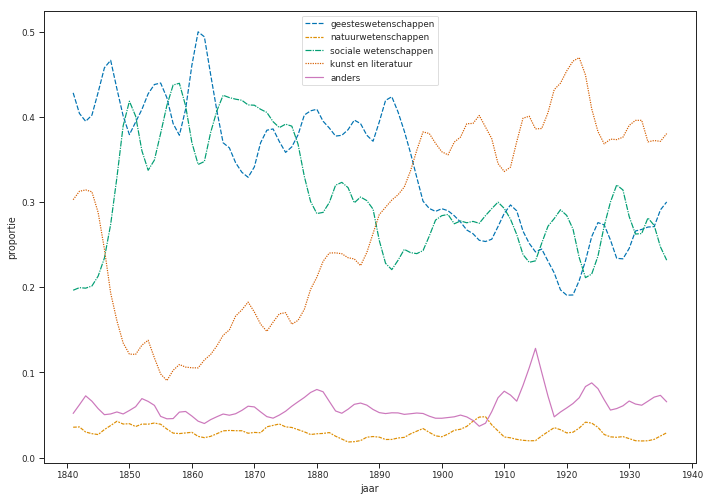

In [87]:
ax = sns.lineplot(
        data=data_overzicht,
        hue_order=['geesteswetenschappen', 'natuurwetenschappen', 'sociale wetenschappen', 'kunst en literatuur', 'anders'],
        palette='colorblind',
        
    )

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.set(xlabel='jaar', ylabel='proportie')

plt.savefig('resultaten/totaaloverzicht.jpg', bbox_inches='tight')
plt.savefig('resultaten/totaaloverzicht.eps', bbox_inches='tight')
plt.savefig('resultaten/totaaloverzicht.pdf', bbox_inches='tight')
plt.show()

# Theologie, Filosofie en Natuurwetenschap

Plot sciences vs. theology, philosophy and these two combined. 

In [76]:
topics = {
    'theologie': theology_topics,
    'filosofie': philosophy_topics,
    'natuurwetenschappen': sciences_topics
}

plot_results_theology = plot(topics, model, mcorpus, fcorpus)

In [77]:
df = pd.DataFrame(plot_results_theology)

In [78]:
df.T.to_csv('resultaten/theologie.csv')

In [79]:
data_theologie = df.rolling(window=5, win_type='triang', axis=1).mean().T

In [91]:
data_theologie.head(100)

filosofie  natuurwetenschappen  theologie
1837        NaN                  NaN        NaN
1838        NaN                  NaN        NaN
1839        NaN                  NaN        NaN
1840        NaN                  NaN        NaN
1841   0.005332             0.035722   0.107629
1842   0.005514             0.036025   0.099869
1843   0.005744             0.030072   0.095308
1844   0.005417             0.028175   0.096173
1845   0.007700             0.027114   0.118712
1846   0.009324             0.033000   0.140730
1847   0.010939             0.037689   0.170445
1848   0.008741             0.042716   0.175247
1849   0.006651             0.039473   0.179788
1850   0.006420             0.039858   0.170164
1851   0.008988             0.036543   0.154105
1852   0.013123             0.039407   0.136857
1853   0.013829             0.039291   0.128346
1854   0.012954             0.040609   0.144630
1855   0.010811             0.039222   0.150058
1856   0.012618             0.033569   0.143140
1857   0.014512             0.028817   0.118405
1858   0.015620             0.028240   0.107079
1859   0.016994             0.029009   0.111127
1860   0.019192             0.029748   0.125379
1861   0.025176             0.024965   0.140472
1862   0.024861             0.023479   0.139681
1863   0.022668             0.025006   0.128596
1864   0.016253             0.028077   0.102611
1865   0.015155             0.031457   0.087983
1866   0.017119             0.031944   0.080377
...         ...                  ...        ...
1907   0.029686             0.048043   0.017788
1908   0.032470             0.038454   0.021786
1909   0.033624             0.031391   0.027971
1910   0.036819             0.024234   0.028744
1911   0.041453             0.023295   0.030624
1912   0.047659             0.021467   0.028121
1913   0.046298             0.020391   0.025184
1914   0.040818             0.019820   0.020428
1915   0.033891             0.019984   0.016223
1916   0.036564             0.025524   0.014806
1917   0.040609             0.030443   0.013384
1918   0.047193             0.035222   0.014083
1919   0.044004             0.032760   0.014368
1920   0.039461             0.029062   0.015145
1921   0.034628             0.029852   0.015097
1922   0.044908             0.034724   0.016974
1923   0.063615             0.041626   0.017982
1924   0.082464             0.040555   0.018424
1925   0.085385             0.035544   0.015792
1926   0.076042             0.027175   0.015321
1927   0.063915             0.024427   0.016291
1928   0.056200             0.023872   0.016697
1929   0.054749             0.024689   0.015112
1930   0.055519             0.022333   0.012568
1931   0.060163             0.019916   0.012216
1932   0.063527             0.019586   0.012064
1933   0.065106             0.019842   0.013912
1934   0.062727             0.021508   0.015065
1935   0.063130             0.025426   0.018812
1936   0.062141             0.029239   0.020214

[100 rows x 3 columns]

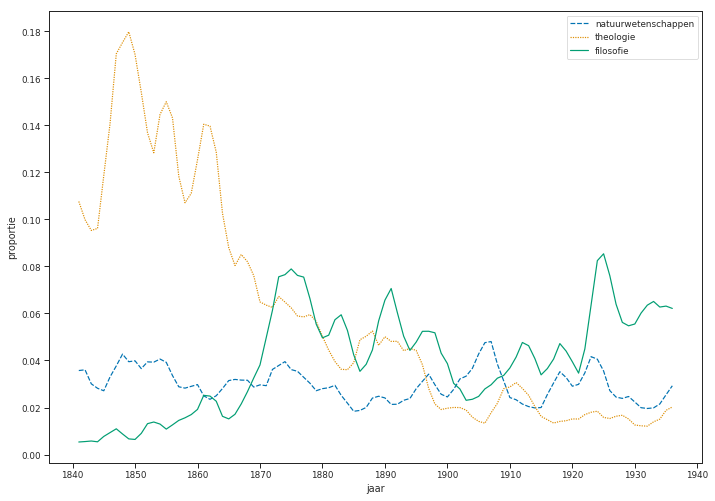

In [90]:
ax = sns.lineplot(
        data=data_theologie,
        hue_order=['natuurwetenschappen', 'theologie', 'filosofie'],
        palette='colorblind'        
    )

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.yaxis.set_major_locator(ticker.MultipleLocator(.02))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax.set(xlabel='jaar', ylabel='proportie')

plt.savefig('resultaten/theologie.jpg', bbox_inches='tight')
plt.savefig('resultaten/theologie.eps', bbox_inches='tight')
plt.savefig('resultaten/theologie.pdf', bbox_inches='tight')
plt.show()